# [FAST DTW](https://pypi.org/project/fastdtw/) (Dynamic Time Warping)

- https://cs.fit.edu/~pkc/papers/tdm04.pdf

Much of this is lifted from `subbundle2`

In [2]:
from utils import *
from dipy.io.streamline import load_tractogram
from dipy.tracking.streamline import set_number_of_points
from fastdtw import fastdtw

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [3]:
dataset_name = 'HCP_retest'
subjects = get_subjects(dataset_name)

myafq = get_afq(dataset_name)

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [4]:
myafq.data_frame

,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,results_dir,gtab,dwi_affine,dwi_img
0,103818,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,105923,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


In [5]:
bundle_names = ['SLF_L']
tg_fnames = {}

for subject in subjects:
    tg_fnames[subject] = {}
    loc = get_iloc(myafq, subject)
    
    for bundle_name in bundle_names:
        tg_fnames[subject][bundle_name] = get_tractogram_filename(myafq, bundle_name, loc)
        print(subject, bundle_name, "tractogram file:", tg_fnames[subject][bundle_name])

103818 SLF_L tractogram file: /Users/bloomdt/AFQ_data/hcp_retest/derivatives/afq/sub-103818/ses-01/clean_bundles/sub-103818_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_L_tractography.trk


In [6]:
streamlines = {}
affines = {}

for subject in subjects:
    streamlines[subject] = {}
    affines[subject] = {}
    
    for bundle_name in bundle_names:
        tg_fname = tg_fnames[subject][bundle_name]
        tractogram = load_tractogram(tg_fname, 'same')
        streamlines[subject][bundle_name] = tractogram.streamlines
        affines[subject][bundle_name] = tractogram.affine
        print(subject, bundle_name, "streamlines:", len(streamlines[subject][bundle_name]))
        print(subject, bundle_name, affines[subject][bundle_name])

103818 SLF_L streamlines: 814
103818 SLF_L [[  -1.25    0.      0.     90.  ]
 [   0.      1.25    0.   -126.  ]
 [   0.      0.      1.25  -72.  ]
 [   0.      0.      0.      1.  ]]


In [7]:
reference_streamlines = {}
for subject in subjects:
    reference_streamlines[subject] = {}
    for bundle_name in bundle_names:
        reference_streamlines[subject][bundle_name] = np.mean(set_number_of_points(streamlines[subject][bundle_name], 100), axis=0)

In [8]:
voxel_freqs = {}

for subject in subjects:
    voxel_freqs[subject] = {}
    for bundle_name in bundle_names:
        voxel_freqs[subject][bundle_name] = [len(streamline) for streamline in streamlines[subject][bundle_name]]

In [9]:
max_streamlines = {}
min_streamlines = {}

for subject in subjects:
    max_streamlines[subject] = {}
    min_streamlines[subject] = {}
    for bundle_name in bundle_names:
        max_streamlines[subject][bundle_name] = streamlines[subject][bundle_name][np.argmax(voxel_freqs[subject][bundle_name])]
        min_streamlines[subject][bundle_name] = streamlines[subject][bundle_name][np.argmin(voxel_freqs[subject][bundle_name])]

In [10]:
sampled_max_streamlines = {}
sampled_min_streamlines = {}

for subject in subjects:
    sampled_max_streamlines[subject] = {}
    sampled_min_streamlines[subject] = {}
    for bundle_name in bundle_names:
        sampled_max_streamlines[subject][bundle_name] = set_number_of_points(max_streamlines[subject][bundle_name], 100)
        sampled_min_streamlines[subject][bundle_name] = set_number_of_points(min_streamlines[subject][bundle_name], 100)

## DTW

### Warp Min/Max Streamlines By Voxel Length

distance: 8056.391983032227


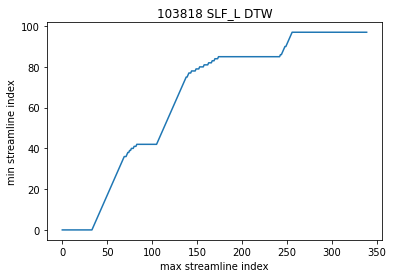

distance: 2998.0969494581223


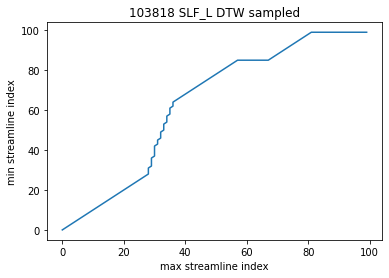

In [11]:
for subject in subjects:
    for bundle_name in bundle_names:
        distance, path = fastdtw(max_streamlines[subject][bundle_name], min_streamlines[subject][bundle_name])
        print('distance:', distance)
        plt.figure()
        plt.title(f'{subject} {bundle_name} DTW')
        # plt.scatter(*zip(*path))
        plt.plot(*zip(*path))
        plt.xlabel('max streamline index')
        plt.ylabel('min streamline index')
        plt.show()

        distance, path = fastdtw(sampled_max_streamlines[subject][bundle_name], sampled_min_streamlines[subject][bundle_name])
        print('distance:', distance)
        plt.figure()
        plt.title(f'{subject} {bundle_name} DTW sampled')
        # plt.scatter(*zip(*path))
        plt.plot(*zip(*path))
        plt.xlabel('max streamline index')
        plt.ylabel('min streamline index')
        plt.show()

### Warp streamlines to (mean) reference length

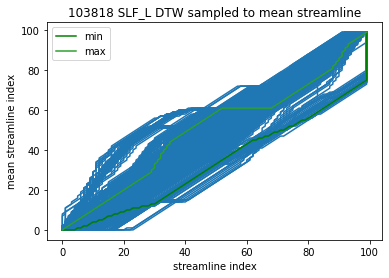

In [12]:
for subject in subjects:
    for bundle_name in bundle_names:
        sampled_streamlines = set_number_of_points(streamlines[subject][bundle_name], 100)
        mean = reference_streamlines[subject][bundle_name]
        
        plt.figure()
        plt.title(f'{subject} {bundle_name} DTW sampled to mean streamline')
        # plt.scatter(*zip(*path))
        for streamline in sampled_streamlines:
            plt.plot(*zip(*fastdtw(streamline, mean)[1]), c='tab:blue')

        plt.plot(*zip(*fastdtw(sampled_min_streamlines[subject][bundle_name], mean)[1]), c='g', label='min')
        plt.plot(*zip(*fastdtw(sampled_max_streamlines[subject][bundle_name], mean)[1]), c='tab:green', label='max')
        plt.xlabel('streamline index')
        plt.ylabel('mean streamline index')
        plt.legend()
        plt.show()

<span style="color:red">**NOTE: streamline position is not the right target**</span>

- Better articulate concerns with this approach

  - Think concern is that should be warping the streamline profiles not the streamlines themselves

<span style="color:blue">**TODO: Calculate weighted streamline profile (in part 3)**</span>